In [1]:
import os
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Synthetic data generation

In [3]:
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed")

In [4]:
import pandas as pd

In [5]:
# choice: 'basic', 'id'
synthesizer = 'basic'

## Load transactions

In [6]:
data = pd.read_csv('data/transactions.csv')
data.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


## Clean dataset

* Leave target columns only (so far: type, operation, amount)
* Filter NaN values
* Convert columns to appropriate type

In [7]:
if synthesizer == 'id':
    data = data[['account_id', 'type', 'operation', 'amount']]
else:
    data = data[['type', 'operation', 'amount']]
data = data.dropna()
data = data[data['type'] != 'VYBER']
if synthesizer == 'id':
    data['account_id'] = data['account_id'].astype(dtype='int32')
    id_normalization = {x: n for n, x in enumerate(data['account_id'].unique())}
    data['account_id'] = data['account_id'].map(arg=id_normalization)
data['type'] = data['type'].astype(dtype='int')
data['type'] = data['type'].astype(dtype='category')
data['operation'] = data['operation'].astype(dtype='int')
data['operation'] = data['operation'].astype(dtype='category')
data['amount'] = data['amount'].astype(dtype='float32')
data.head(10)

,type,operation,amount
0,1,2,700.0
1,1,2,7268.0
2,1,2,14440.0
3,1,2,49752.0
4,1,2,21899.0
5,0,3,34700.0
7,1,2,30192.0
8,0,0,9612.0
9,1,2,31038.0
10,0,3,25200.0


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
data, test = train_test_split(data, test_size=0.2, random_state=42)

## Train model and synthesized data

In [10]:
if synthesizer == 'id':
    from synthesized.core import IdSynthesizer
    synthesizer = IdSynthesizer
elif synthesizer == 'basic':
    from synthesized.core import BasicSynthesizer
    synthesizer = BasicSynthesizer

Instructions for updating:
Use the retry module or similar alternatives.


In [11]:
with synthesizer(dtypes=data.dtypes) as synthesizer:
    synthesizer.learn(data=data, verbose=5000)
    synthesized = synthesizer.synthesize(n=10000)

5000: 9.80e+07
10000: 9.49e+07
15000: 1.15e+08
20000: 5.95e+07
25000: 4.10e+07
30000: 2.46e+07
35000: 1.84e+07
40000: 1.08e+07
45000: 6.04e+05
50000: 1.17e+07


## Display synthesized data

In [12]:
synthesized.head(10)

,amount,operation,type
0,1505.996216,3,0
1,2958.098877,3,0
2,9.667295,3,0
3,8053.226074,3,1
4,9.667295,3,0
5,5227.492188,3,0
6,9.667295,3,0
7,1984.592163,3,0
8,39375.953125,2,1
9,9.667295,3,0


# Visualization of original and synthetic data

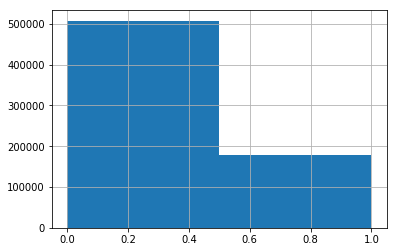

In [13]:
data['type'].hist(bins=2, range=[0, 1])

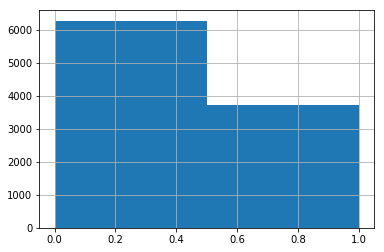

In [14]:
synthesized['type'].hist(bins=2, range=[0, 1])

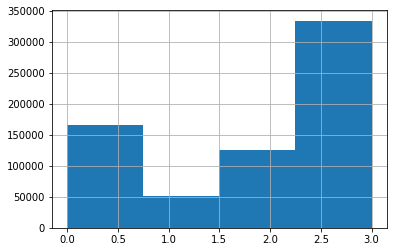

In [15]:
data['operation'].hist(bins=4, range=[0, 3])

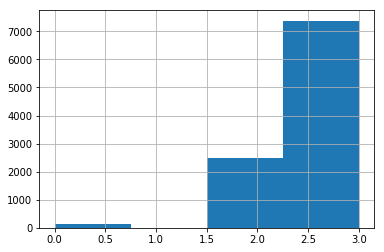

In [16]:
synthesized['operation'].hist(bins=4, range=[0, 3])

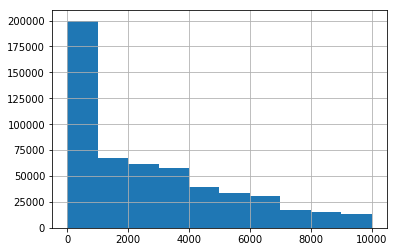

In [17]:
data['amount'].hist(bins=10, range=[0.0, 10000.0])

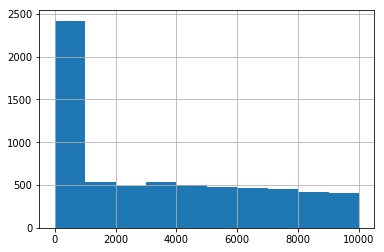

In [18]:
synthesized['amount'].hist(bins=10, range=[0.0, 10000.0])

# Tests to confirm the utility of synthetic data 

In [19]:
from synthesized.testing.testing_environment import Testing, ColumnType
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [20]:
synthesized.head(5)

,amount,operation,type
0,1505.996216,3,0
1,2958.098877,3,0
2,9.667295,3,0
3,8053.226074,3,1
4,9.667295,3,0


In [21]:
testing = Testing(data, test, synthesized, schema={
    'type': ColumnType.CATEGORICAL,
    'operation': ColumnType.CATEGORICAL,
    'amount': ColumnType.CONTINUOUS,
})

In [22]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

,target_column,estimator,dummy_original_score,original_score,synth_score,orig_error,synth_error,score_utility,error_utility
0,amount,DecisionTreeRegressor,0.000000,0.199508,0.108271,9000.333861,9499.409049,0.542689,0.947463
1,amount (categorical reduction),DecisionTreeClassifier,0.757379,0.757379,0.740158,0.242621,0.259842,NaN,0.933727
2,operation,DecisionTreeClassifier,0.489277,0.976423,0.592640,0.023577,0.407360,0.212182,0.057879
3,type,DecisionTreeClassifier,0.741921,1.000000,0.792018,0.000000,0.207982,0.194115,0.000000


In [23]:
testing.compare_marginal_distributions(target_column='operation', conditional_column='amount')

,amount,operation EMD
0,"[0.0, 21825.0)",0.329998
1,"[21825.0, 43650.0)",0.421517
2,"[43650.0, 65475.0)",0.580544
3,"[65475.0, 87300.0)",inf


In [24]:
testing.compare_marginal_distributions(target_column='type', conditional_column='amount', bins=10)

,amount,type EMD
0,"[0.0, 8730.0)",0.080790
1,"[8730.0, 17460.0)",0.325853
2,"[17460.0, 26190.0)",0.310363
3,"[26190.0, 34920.0)",0.352213
4,"[34920.0, 43650.0)",0.243694
5,"[43650.0, 52380.0)",0.192293
6,"[52380.0, 61110.0)",0.778721
7,"[61110.0, 69840.0)",inf
8,"[69840.0, 78570.0)",inf
9,"[78570.0, 87300.0)",inf


# Tests to confirm the security of original data 

In [25]:
from synthesized.testing.linkage_attack import identify_attacks, Column, show_attacked_data, eradicate_attacks

## Focus on a small chunk of original data for demo purposes

In [26]:
data_orig_reduced = data.head(30000)

## Define schema for security checks

Each attribute in a dataset has the following properties to be specified by the user
1. "key_attribute" - whether the attribute can be available to the attacker as background knowledge 
2. "sensitive" - whether the attribute is SPI 
3. "categorical" - wtether the attribute is a categorical variable

In [27]:
schema = {
    'type': Column(key_attribute=False, sensitive=False, categorical=True),
    'operation': Column(key_attribute=False, sensitive=True, categorical=True),
    'amount': Column(key_attribute=True, sensitive=True, categorical=False),
}

## Identify and demonstrate vulnerabilities in synthetic data

In [28]:
attacks = identify_attacks(data_orig_reduced, synthesized, schema)

In [29]:
len(attacks)

554

In [30]:
show_attacked_data(data_orig_reduced, synthesized, attacks[3], schema)

original df subset: 
         type  operation   amount
59500      1          2  22634.0
146334     1          2  22623.0
383940     1          2  22635.0


 synthetic df subset: 
            amount operation type
741  22634.449219         2    1


## Clear the synthetic dataset from vulnerabilities

In [31]:
cleared_df = eradicate_attacks(data_orig_reduced, synthesized, attacks, schema)

remaining attacks :  554


/Users/nicolai/synthesized/synthesized/testing/testing_environment.py:213: RuntimeWarning:

invalid value encountered in true_divide

/Users/nicolai/synthesized/synthesized/testing/testing_environment.py:212: RuntimeWarning:

invalid value encountered in true_divide



remaining attacks :  3


## Demonstrate the security of synthetic data

In [32]:
new_attacks = identify_attacks(data_orig_reduced, cleared_df, schema)

In [33]:
len(new_attacks)

0

## Demonstrate the utility of synthetic data cleared from all vulnerabilities

In [37]:
testing = Testing(data, cleared_df, synthesized, schema={
    'type': ColumnType.CATEGORICAL,
    'operation': ColumnType.CATEGORICAL,
    'amount': ColumnType.CONTINUOUS,
})

In [38]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

,target_column,estimator,dummy_original_score,original_score,synth_score,orig_error,synth_error,score_utility,error_utility
0,amount,DecisionTreeRegressor,0.000000,0.561211,0.580824,5598.947228,5472.386841,1.034947,1.023127
1,amount (categorical reduction),DecisionTreeClassifier,0.598238,0.598238,0.740321,0.401762,0.259679,0.000000,1.547149
2,operation,DecisionTreeClassifier,0.770712,0.451220,0.943186,0.548780,0.056814,0.000000,9.659284
3,type,DecisionTreeClassifier,0.607336,0.825397,0.998161,0.174603,0.001839,1.792277,94.947368


## Demonstrate the synthetic dataset to be released to the user

In [39]:
synthesized

,amount,operation,type
0,1505.996216,3,0
1,2958.098877,3,0
2,9.667295,3,0
3,8053.226074,3,1
4,9.667295,3,0
5,5227.492188,3,0
6,9.667295,3,0
7,1984.592163,3,0
8,39375.953125,2,1
9,9.667295,3,0
